<center><h2>ALTEGRAD Project</h2>

<hr>
<span style="font-variant: small-caps;">Xavier Jiménez, Jean Quentin, Sacha Revol</span><br>
<hr>
</center>

# Imports

In [119]:
import networkx as nx
import os
import csv
import numpy as np
import pandas as pd
from random import randint
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from tqdm import tqdm

# !pip install pip install karateclub
from gensim.models.doc2vec import Doc2Vec
from os import path
import pickle
from scipy import spatial
import random
from sklearn import preprocessing
from gensim.models import KeyedVectors
from sklearn.metrics import pairwise

from sklearn.model_selection import train_test_split
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from sklearn.ensemble import RandomForestClassifier

import shap


# Load preprocessed files

These files are created in `Preprocessing.ipynb`

In [120]:
def load_authors():
    """Read the abstract of each paper"""
    
    try:
        print('Loading unique authors preprocessed')
        a_file = open("data/unique_authors_dict.pkl", "rb")
        authors = pickle.load(a_file)
        a_file.close()
    except:
        raise SyntaxError("File 'unique_authors_dict.pkl' was not found in 'data/'")
    
    return authors

In [121]:
def load_abstracts():
    """Read the abstract of each paper"""
    
    try:
        print('Loading abstract preprocessed')
        a_file = open("data/abstract_preprocessed.pkl", "rb")
        abstracts = pickle.load(a_file)
        a_file.close()
    except:
        raise SyntaxError("File 'abstract_preprocessed.pkl' was not found in 'data/'")
    
    return abstracts

# Functions

## Training and submission

In [122]:
def train(X_train, X_test, y_train, y_test = None, normalize = True, model = LogisticRegression(max_iter = 300)):
    if normalize:
        scaler = preprocessing.StandardScaler().fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.fit_transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    y_pred = y_pred[:,1]
    if y_test is not None:
        print('Validation loss = {:.4f}'.format(log_loss(y_test, y_pred)))
    else:
        # Write predictions to a file
        print('Creating submission')
        predictions = zip(range(len(y_pred)), y_pred)
        os.remove("data/submission.csv")
        with open("data/submission.csv","w") as pred:
            csv_out = csv.writer(pred)
            csv_out.writerow(['id','predicted'])
            for row in predictions:
                csv_out.writerow(row)
        print('Submision created')
    return y_pred, model

## Feature matrix creation

### Common functions for matrix creation

In [123]:
def load_info(validation = True):
    """This function returns validation/test node pairs list and
    validation/test + train random nodes that will be used to create
    feature matrix. These lists have a fixed seed.

    Args:
        validation (bool, optional): If True, will return validation lists.
        Else, will return test lists. Defaults to True.

    Returns:
        lists: validation/test node pairs list and labels
    """
      
        
    if validation:
        node_pairs = pd.read_csv('data/train_val_node_pairs.csv')
        labels = pd.read_csv('data/train_val_labels.csv')
        
        train_node_pairs, val_node_pairs, train_labels, val_labels = train_test_split(node_pairs, 
                                                                                      labels, 
                                                                                      train_size=0.8, 
                                                                                      test_size=0.2, 
                                                                                      random_state=42)
        np.save('data/y_train_val', train_labels.to_numpy().ravel())
        np.save('data/y_val', val_labels.to_numpy().ravel())
        
        return train_node_pairs.to_numpy(), val_node_pairs.to_numpy()
    else:
        test_node_pairs = list()
        with open('data/test.txt', 'r') as f:
            for line in f:
                t = line.split(',')
                test_node_pairs.append((int(t[0]), int(t[1])))
                
        train_node_pairs = pd.read_csv('data/train_test_node_pairs.csv')
        train_labels = pd.read_csv('data/train_test_labels.csv')
        
        np.save('data/y_train', train_labels.to_numpy().ravel())
                
        return train_node_pairs.to_numpy(), test_node_pairs

### Default matrix creation

In [124]:
def create_default_matrix(G_train, G_test, validation = True):
    """Creates feature matrix with baseline features. 

    Args:
        G (NetworkX Graph): A Graph loaded with NetworkX library.
        validation (bool, optional): If True, will return validation lists.
        Else, will return test lists. Defaults to True.
    """

    n_features = 8
    
    
    if validation:
        train_node_pairs, val_node_pairs = load_info(validation = validation)
        X_val = np.zeros((len(val_node_pairs), n_features))
    else:
        train_node_pairs, test_node_pairs = load_info(validation = validation)
        X_test = np.zeros((len(test_node_pairs), n_features))           
    X_train = np.zeros((len(train_node_pairs), n_features))
    
    authors = load_authors()
    abstracts = load_abstracts()
    
    for i, train_edge in tqdm(enumerate(train_node_pairs)):
        X_train = fill_default_matrix(i, G_train, X_train, train_edge, authors, abstracts)
    if validation:
        np.save('data/X_train_val_default.npy', X_train)
        for i, val_edge in tqdm(enumerate(val_node_pairs)):
            X_val = fill_default_matrix(i, G_test, X_val, val_edge, authors, abstracts)
        np.save('data/X_val_default.npy', X_val)
    else:
        np.save('data/X_train_default.npy', X_train)
        for i, test_edge in tqdm(enumerate(test_node_pairs)):
            X_test = fill_default_matrix(i, G_test, X_test, test_edge, authors, abstracts)
        np.save('data/X_test_default.npy', X_test)
        
        
def fill_default_matrix(i, G, X, edge, authors, abstracts):
    """Fills each line of the default feature matrix.

    Args:
        i (int): matrix line.
        G (nx graph): Graph loaded with NetworkX.
        X (np.ndarray): Shape (2 x n_edges, n_features)
        edge (list): list of tupple of nodes.

    Returns:
        np.ndarray: if p=1, returns X, y filled. Elif p=2, returns X filled.
    """
    deg0, deg1 = G.degree(edge[0]), G.degree(edge[1])
    X[i,0] = len(abstracts[edge[0]]) + len(abstracts[edge[1]])
    X[i,1] = abs(len(abstracts[edge[0]]) - len(abstracts[edge[1]]))
    X[i,2] = len(set(abstracts[edge[0]]).intersection(set(abstracts[edge[1]])))
    X[i,3] = deg0 + deg1
    X[i,4] = abs(deg0 - deg1)
    X[i,5] = len(set(authors[edge[0]]).intersection(set(authors[edge[1]])))
    X[i,6] = nx.average_degree_connectivity(G, nodes = edge[0])[deg0] + nx.average_degree_connectivity(G, nodes = edge[1])[deg1]
    X[i,7] = abs(nx.average_degree_connectivity(G, nodes = edge[0])[deg0] - nx.average_degree_connectivity(G, nodes = edge[1])[deg1])

    return X

### Param matrix creation

In [134]:
def create_param_matrix(G_train, G_test, authors = False, validation = True):
    """Creates Graph parameters feature matrix. 

    Args:
        G (NetworkX Graph): A Graph loaded with NetworkX library.
        validation (bool, optional): If True, will return validation lists.
        Else, will return test lists. Defaults to True.
    """

    
    n_features = 2*9
    
    if validation:
        train_node_pairs, val_node_pairs = load_info(validation = validation)
        X_val = np.zeros((len(val_node_pairs), n_features))
    else:
        train_node_pairs, test_node_pairs = load_info(validation = validation)
        X_test = np.zeros((len(test_node_pairs), n_features))           
    X_train = np.zeros((len(train_node_pairs), n_features))
    
    
    avg_neighbor_degree = nx.average_neighbor_degree(G_train)
    pagerank = nx.pagerank(G_train)
    eig_centrality = nx.eigenvector_centrality_numpy(G_train)
    greedy_color = nx.greedy_color(G_train)
    triangles = nx.triangles(G_train)
    
    core_number = nx.core_number(G_train)
    onion_number = nx.onion_layers(G_train)
    degree_centrality = nx.degree_centrality(G_train)
    clustering = nx.clustering(G_train)

    parameters = {'avg_neighbor_degree': avg_neighbor_degree, 'pagerank': pagerank, 'eig_centrality': eig_centrality,
                  'greedy_color': greedy_color, 'triangles': triangles, 'core_number': core_number, 'onion_number': onion_number,
                  'degree_centrality': degree_centrality, 'clustering': clustering}
                
    for i, train_edge in tqdm(enumerate(train_node_pairs)):
        X_train = fill_param_matrix(i, X_train, train_edge, **parameters)
    avg_neighbor_degree = nx.average_neighbor_degree(G_test)
    pagerank = nx.pagerank(G_test)
    eig_centrality = nx.eigenvector_centrality_numpy(G_test)
    greedy_color = nx.greedy_color(G_test)
    triangles = nx.triangles(G_test)
    
    core_number = nx.core_number(G_test)
    onion_number = nx.onion_layers(G_test)
    avg_neighbor_degree = nx.average_neighbor_degree(G_test)
    degree_centrality = nx.degree_centrality(G_test)
    clustering = nx.clustering(G_test)
    
    parameters = {'avg_neighbor_degree': avg_neighbor_degree, 'pagerank': pagerank, 'eig_centrality': eig_centrality,
                  'greedy_color': greedy_color, 'triangles': triangles, 'core_number': core_number, 'onion_number': onion_number,
                  'degree_centrality': degree_centrality, 'clustering': clustering}
    if validation:
        if not authors:
            np.save('data/X_train_val_param', X_train)
        else:
            np.save('data/X_train_val_param_authors', X_train)
        for i, val_edge in tqdm(enumerate(val_node_pairs)):
            X_val = fill_param_matrix(i, X_val, val_edge, **parameters)
        if not authors:
            np.save('data/X_val_param', X_val)
        else:
            np.save('data/X_val_param_authors', X_val)
    else:
        np.save('data/X_train_param', X_train)
        for i, test_edge in tqdm(enumerate(test_node_pairs)):
            X_test = fill_param_matrix(i, X_test, test_edge, **parameters)
        if not authors:
            np.save('data/X_test_param.npy', X_test)
        else:
            np.save('data/X_test_param_authors.npy', X_test)
        
        
def fill_param_matrix(i, X, edge, avg_neighbor_degree, pagerank, eig_centrality, greedy_color, triangles, 
                      core_number, onion_number, degree_centrality, clustering):
    """Fills each line of the Graph parameters feature matrix."""
    
    X[i,0] = avg_neighbor_degree[edge[0]] + avg_neighbor_degree[edge[1]]
    X[i,1] = abs(avg_neighbor_degree[edge[0]] - avg_neighbor_degree[edge[1]])

    X[i,2] = pagerank[edge[0]] + pagerank[edge[1]]
    X[i,3] = abs(pagerank[edge[0]] - pagerank[edge[1]])

    X[i,4] = eig_centrality[edge[0]] + eig_centrality[edge[1]]
    X[i,5] = abs(eig_centrality[edge[0]] - eig_centrality[edge[1]])

    X[i,6] = greedy_color[edge[0]] + greedy_color[edge[1]]
    X[i,7] = abs(greedy_color[edge[0]] - greedy_color[edge[1]])

    X[i,8] = triangles[edge[0]] + triangles[edge[1]]
    X[i,9] = abs(triangles[edge[0]] - triangles[edge[1]])
    
    X[i,10] = core_number[edge[0]] + core_number[edge[1]]
    X[i,11] = abs(core_number[edge[0]] - core_number[edge[1]])
    
    X[i,12] = onion_number[edge[0]] + onion_number[edge[1]]
    X[i,13] = abs(onion_number[edge[0]] - onion_number[edge[1]])
    
    X[i,14] = degree_centrality[edge[0]] + degree_centrality[edge[1]]
    X[i,15] = abs(degree_centrality[edge[0]] -degree_centrality[edge[1]])
    
    X[i,16] = clustering[edge[0]] + clustering[edge[1]]
    X[i,17] = abs(clustering[edge[0]] - clustering[edge[1]])
    
    return X

### Embedding Matrix creation

In [126]:
def create_embeddings_matrix(distance, validation = True):
    """Creates Graph embeddings feature matrix.

    Args:
        distance (scipy spatial distance): Function that takes two 1d arrays
        and outputs a float. Recommended: cosine distance.
        validation (bool, optional): If True, will return validation lists.
        Else, will return test lists. Defaults to True.
    """

    n2v_parameters = {'walk_number': 10, 'walk_length': 15, 'dimensions': 64, 'window_size': 5}
    d2v_parameters = {'vector_size':64, 'window':5, 'min_count':2, 'epochs':100}
    walkets_parameters = {'walk_number': 10, 'walk_length': 80, 'dimensions': 64, 'window_size': 5}

    d2v = Doc2Vec.load("data/abstracts_embedding_doc2vec_vs{:d}_w{:d}_mc{:d}_e{:d}".format(d2v_parameters['vector_size'], d2v_parameters['window'],
                                                                               d2v_parameters['min_count'], d2v_parameters['epochs']))

    specter_emb = np.load('data/embeddings_14_02.npy')
    
    co_authors_emb = np.load('data/sum_papers_features_from_embedding_n2v_unique_co_authors_wn10_wl15_d64_ws5.npy')
        
    embeddings = [specter_emb, co_authors_emb, d2v]
    
    if validation:
        embeddings_val = [specter_emb, co_authors_emb, d2v]
        
        n2v = np.load('data/embedding_n2v_train_val_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(n2v_parameters['walk_number'], n2v_parameters['walk_length'],
                                                                n2v_parameters['dimensions'], n2v_parameters['window_size']))
        
        walkets = np.load('data/embedding_Walklets_train_val_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(walkets_parameters['walk_number'], walkets_parameters['walk_length'],
                                                                walkets_parameters['dimensions'], walkets_parameters['window_size']))
        # authors_citation_emb = np.load('data/mean_papers_features_from_embedding_n2v_citation_graph_train_wn10_wl15_d64_ws5.npy')
        authors_citation_emb = np.load('data/mean_papers_features_from_embedding_n2v_unique_citation_graph_train_wn10_wl15_d64_ws5.npy')
        authors_citation_walklets = np.load('data/mean_papers_features_from_embedding_Walklets_citation_graph_train_wn10_wl80_d64_ws5.npy')
    

        embeddings.append(n2v)
        embeddings_val.append(n2v)
        embeddings.append(walkets)
        embeddings_val.append(walkets)
        embeddings.append(authors_citation_emb)
        embeddings_val.append(authors_citation_emb)
        embeddings.append(authors_citation_walklets)
        embeddings_val.append(authors_citation_walklets)
        
        n_features = len(embeddings)
        print(f'n_features = {n_features}')
        train_node_pairs, val_node_pairs = load_info(validation = validation)
        X_val = np.zeros((len(val_node_pairs), n_features))
    else:
        embeddings_test = [specter_emb, co_authors_emb, d2v]
        
        n2v_test = np.load('data/embedding_n2v_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(n2v_parameters['walk_number'], n2v_parameters['walk_length'],
                                                                n2v_parameters['dimensions'], n2v_parameters['window_size']))
        n2v = np.load('data/embedding_n2v_train_test_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(n2v_parameters['walk_number'], n2v_parameters['walk_length'],
                                                                n2v_parameters['dimensions'], n2v_parameters['window_size']))
        walkets_test = np.load('data/embedding_Walklets_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(walkets_parameters['walk_number'], walkets_parameters['walk_length'],
                                                                walkets_parameters['dimensions'], 4))
        walkets = np.load('data/embedding_Walklets_train_test_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(walkets_parameters['walk_number'], walkets_parameters['walk_length'],
                                                                walkets_parameters['dimensions'], walkets_parameters['window_size']))
        authors_citation_emb_test = np.load('data/mean_papers_features_from_embedding_n2v_unique_citation_graph_complete_wn10_wl15_d64_ws5.npy')
        authors_citation_emb = np.load('data/mean_papers_features_from_embedding_n2v_unique_citation_graph_test_wn10_wl15_d64_ws5.npy')
        
        embeddings.append(n2v)
        embeddings_test.append(n2v_test)
        embeddings.append(walkets)
        embeddings_test.append(walkets_test)
        embeddings.append(authors_citation_emb)
        embeddings_test.append(authors_citation_emb_test)
        
        n_features = len(embeddings)
        print(f'n_features = {n_features}')
        train_node_pairs, test_node_pairs = load_info(validation = validation)
        X_test = np.zeros((len(test_node_pairs), n_features))           
    X_train = np.zeros((len(train_node_pairs), n_features))



    for i, train_edge in tqdm(enumerate(train_node_pairs)):
        X_train  = fill_embeddings_matrix(i, X_train, train_edge, embeddings, distance)
    if validation:
        np.save('data/X_train_val_embeddings', X_train)
        for i, val_edge in tqdm(enumerate(val_node_pairs)):
            X_val = fill_embeddings_matrix(i, X_val, val_edge, embeddings_val, distance)
        np.save('data/X_val_embeddings', X_val)
    else:
        np.save('data/X_train_embeddings', X_train)
        for i, test_edge in tqdm(enumerate(test_node_pairs)):
            X_test = fill_embeddings_matrix(i, X_test, test_edge,  embeddings_test, distance)
        np.save('data/X_test_embeddings', X_test)


def fill_embeddings_matrix(i, X, edge, embeddings, distance):
    """Fills each line of the Graph embedding feature matrix.

    Args:
        i (int): matrix line.
        G (nx graph): Graph loaded with NetworkX.
        X (np.ndarray): Shape (2 x n_edges, n_features)
        edge (list): list of tupple of nodes.
        embeddings (list): list of np.ndarrays containing embeddings for each node in the Graph
        distance (scipy spatial distance): Function that takes two 1d arrays
        and outputs a float. Recommended: cosine distance.

    Returns:
        np.ndarray: if p=1, returns X, y filled. Elif p=2, returns X filled.
    """

    for j, emb in enumerate(embeddings):
        if j == 2:
            try:
                X[i,j] = emb.dv.similarity(edge[0], edge[1])
            except:
                X[i,j] = emb.docvecs.similarity(edge[0], edge[1])
        else:
            X[i,j] = 1 - distance(emb[edge[0]], emb[edge[1]])

    return X

### Edge embedding

In [127]:
def create_edge_embeddings_matrix(validation = True):
    """Creates Graph embeddings feature matrix.

    Args:
        distance (scipy spatial distance): Function that takes two 1d arrays
        and outputs a float. Recommended: cosine distance.
        validation (bool, optional): If True, will return validation lists.
        Else, will return test lists. Defaults to True.
    """

    n2v_parameters = {'walk_number': 10, 'walk_length': 15, 'dimensions': 64, 'window_size': 5}
    walkets_parameters = {'walk_number': 10, 'walk_length': 80, 'dimensions': 64, 'window_size': 5}
    
    specter_emb = np.load('data/embeddings_14_02.npy')
    
    co_authors_emb = np.load('data/sum_papers_features_from_embedding_n2v_unique_co_authors_wn10_wl15_d64_ws5.npy')
        
    embeddings = [specter_emb, co_authors_emb]
    
    if validation:
        embeddings_val = [specter_emb, co_authors_emb]
        
        n2v = np.load('data/embedding_n2v_train_val_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(n2v_parameters['walk_number'], n2v_parameters['walk_length'],
                                                                n2v_parameters['dimensions'], n2v_parameters['window_size']))
        
        walkets = np.load('data/embedding_Walklets_train_val_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(walkets_parameters['walk_number'], walkets_parameters['walk_length'],
                                                                walkets_parameters['dimensions'], walkets_parameters['window_size']))
        authors_citation_emb = np.load('data/mean_papers_features_from_embedding_n2v_unique_citation_graph_train_wn10_wl15_d64_ws5.npy')

        embeddings.append(n2v)
        embeddings_val.append(n2v)
        embeddings.append(walkets)
        embeddings_val.append(walkets)
        embeddings.append(authors_citation_emb)
        embeddings_val.append(authors_citation_emb)
        n_features = np.sum([embeddings[i].shape[1] for i in range(len(embeddings))])
        print(f'n_features = {n_features}')
        train_node_pairs, val_node_pairs = load_info(validation = validation)
        X_val = np.zeros((len(val_node_pairs), n_features))
    else:
        embeddings_test = [specter_emb, co_authors_emb]
        
        n2v_test = np.load('data/embedding_n2v_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(n2v_parameters['walk_number'], n2v_parameters['walk_length'],
                                                                n2v_parameters['dimensions'], n2v_parameters['window_size']))
        n2v = np.load('data/embedding_n2v_train_test_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(n2v_parameters['walk_number'], n2v_parameters['walk_length'],
                                                                n2v_parameters['dimensions'], n2v_parameters['window_size']))
        walkets_test = np.load('data/embedding_Walklets_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(walkets_parameters['walk_number'], walkets_parameters['walk_length'],
                                                                walkets_parameters['dimensions'], 4))
        walkets = np.load('data/embedding_Walklets_train_test_wn{:d}_wl{:d}_d{:d}_ws{:d}.npy'.format(walkets_parameters['walk_number'], walkets_parameters['walk_length'],
                                                                walkets_parameters['dimensions'], walkets_parameters['window_size']))
        authors_citation_emb_test = np.load('data/mean_papers_features_from_embedding_n2v_citation_graph_complete_wn10_wl15_d64_ws5.npy')
        authors_citation_emb = np.load('data/mean_papers_features_from_embedding_n2v_citation_graph_test_wn10_wl15_d64_ws5.npy')
        
        embeddings.append(n2v)
        embeddings_test.append(n2v_test)
        embeddings.append(walkets)
        embeddings_test.append(walkets_test)
        embeddings.append(authors_citation_emb)
        embeddings_test.append(authors_citation_emb_test)
        
        n_features = np.sum([embeddings[i].shape[1] for i in range(len(embeddings))])
        print(f'n_features = {n_features}')
        train_node_pairs, test_node_pairs = load_info(validation = validation)
        X_test = np.zeros((len(test_node_pairs), n_features))           
    X_train = np.zeros((len(train_node_pairs), n_features))



    for i, train_edge in tqdm(enumerate(train_node_pairs)):
        X_train  = fill_edge_embeddings_matrix(i, X_train, train_edge, embeddings)
    if validation:
        np.save('data/X_train_val_edge_embeddings', X_train)
        for i, val_edge in tqdm(enumerate(val_node_pairs)):
            X_val = fill_edge_embeddings_matrix(i, X_val, val_edge, embeddings_val)
        np.save('data/X_val_edge_embeddings', X_val)
    else:
        np.save('data/X_train_edge_embeddings', X_train)
        for i, test_edge in tqdm(enumerate(test_node_pairs)):
            X_test = fill_edge_embeddings_matrix(i, X_test, test_edge,  embeddings_test)
        np.save('data/X_test_edge_embeddings', X_test)

def operator_hadamard(u, v):
    return u * v

def fill_edge_embeddings_matrix(i, X, edge, embeddings):
    """Fills each line of the Graph embedding feature matrix.

    Args:
        i (int): matrix line.
        G (nx graph): Graph loaded with NetworkX.
        X (np.ndarray): Shape (2 x n_edges, n_features)
        edge (list): list of tupple of nodes.
        embeddings (list): list of np.ndarrays containing embeddings for each node in the Graph
        distance (scipy spatial distance): Function that takes two 1d arrays
        and outputs a float. Recommended: cosine distance.

    Returns:
        np.ndarray: if p=1, returns X, y filled. Elif p=2, returns X filled.
    """
    size = 0
    for j, emb in enumerate(embeddings):
        X[i, size : size + emb.shape[1]] = operator_hadamard(emb[edge[0]], emb[edge[1]])
        size += emb.shape[1]

    return X

### Other features

In [128]:
def create_new_feature_matrix(G_train, G_test, measures, authors = False, validation = True):
    n_features = len(measures)
    
    if validation:
        train_node_pairs, val_node_pairs = load_info(validation = validation)
        X_val = np.zeros((len(val_node_pairs), n_features))
    else:
        train_node_pairs, test_node_pairs = load_info(validation = validation)
        X_test = np.zeros((len(test_node_pairs), n_features))           
    X_train = np.zeros((len(train_node_pairs), n_features))
        
    for i, train_edge in tqdm(enumerate(train_node_pairs)):
        X_train = fill_new_feature_matrix(i, G_train, X_train, train_edge, measures)
    
    if validation:
        if not authors:
            np.save('data/X_train_val_new_features', X_train)
        else:
            np.save('data/X_train_val_new_features_authors', X_train)
        for i, val_edge in tqdm(enumerate(val_node_pairs)):
            X_val = fill_new_feature_matrix(i, G_test, X_val, val_edge, measures)
        if not authors:
            np.save('data/X_val_new_features', X_val)
        else:
            np.save('data/X_val_new_features_authors', X_val)

    else:
        if not authors:
            np.save('data/X_train_new_features', X_train)
        else:
            np.save('data/X_train_new_features_authors', X_train)
        for i, test_edge in tqdm(enumerate(test_node_pairs)):
            X_test = fill_new_feature_matrix(i, G_test, X_test, test_edge, measures)
        if not authors:
            np.save('data/X_test_new_features', X_test)
        else:
            np.save('data/X_test_new_features_authors', X_test)
        
        
def fill_new_feature_matrix(i, G, X, edge, measures):
    for j, measure in enumerate(measures):
        X[i,j] = measure(G, edge[0], edge[1])
    
    return X

### Matrix concatenation & loading

In [151]:
def concatenate_matrix(default = True, param = True, authors_param = False, embeddings = True, edge_embeddings = False, 
                       new_feature = True, authors_new_feature = False, validation = True):
    
    bool_list = [default, param, authors_param, embeddings, edge_embeddings, new_feature, authors_new_feature]
    
    if validation:
        y_train = np.load('data/y_train_val.npy')
        X_train_default = np.load('data/X_train_val_default.npy')
        X_train_param = np.load('data/X_train_val_param.npy')
        X_train_param_authors = np.load('data/X_train_val_param_authors.npy')
        X_train_embeddings = np.load('data/X_train_val_embeddings.npy')
        if edge_embeddings:
            X_train_edge_embeddings = np.load('data/X_train_val_edge_embeddings.npy')
        else:
            X_train_edge_embeddings = None
        X_train_new_feature = np.load('data/X_train_val_new_features.npy')
        if authors_new_feature:
            X_train_new_feature_authors = np.load('data/X_train_val_new_features_authors.npy')
        else:
            X_train_new_feature_authors = None
        X_train_list = [X for i,X in enumerate([X_train_default, X_train_param, X_train_param_authors, X_train_embeddings, 
                                                X_train_edge_embeddings, X_train_new_feature, X_train_new_feature_authors]) if bool_list[i]]
        X_train = np.concatenate(X_train_list, axis=1)
        np.save('data/X_train_val', X_train)
    
        X_val_default = np.load('data/X_val_default.npy')
        X_val_param = np.load('data/X_val_param.npy')
        X_val_param_authors = np.load('data/X_val_param_authors.npy')
        X_val_embeddings = np.load('data/X_val_embeddings.npy')
        if edge_embeddings:
            X_val_edge_embeddings = np.load('data/X_val_edge_embeddings.npy')
        else:
            X_val_edge_embeddings = None
        X_val_new_feature = np.load('data/X_val_new_features.npy')
        if authors_new_feature:
            X_val_new_feature_authors = np.load('data/X_val_new_features_authors.npy')
        else:
            X_val_new_feature_authors = None
        X_val_list = [X for i,X in enumerate([X_val_default, X_val_param, X_val_param_authors, X_val_embeddings, 
                                              X_val_edge_embeddings, X_val_new_feature, X_val_new_feature_authors]) if bool_list[i]]
        X_val = np.concatenate(X_val_list, axis=1)
        np.save('data/X_val', X_val)
        y_val = np.load('data/y_val.npy')
        return X_train, X_val, y_train, y_val
    else:
        y_train = np.load('data/y_train.npy')
        X_train_default = np.load('data/X_train_default.npy')
        X_train_param = np.load('data/X_train_param.npy')
        if authors_param:
            X_train_param_authors = np.load('data/X_train_param_authors.npy')
        else:
            X_train_param_authors = None
        X_train_embeddings = np.load('data/X_train_embeddings.npy')
        if edge_embeddings:
            X_train_edge_embeddings = np.load('data/X_train_edge_embeddings.npy')
        else:
            X_train_edge_embeddings = None
        X_train_new_feature = np.load('data/X_train_new_features.npy')
        if authors_new_feature:
            X_train_new_feature_authors = np.load('data/X_train_new_features_authors.npy')
        else:
            X_train_new_feature_authors = None
        X_train_list = [X for i,X in enumerate([X_train_default, X_train_param, X_train_param_authors, X_train_embeddings, 
                                                X_train_edge_embeddings, X_train_new_feature, X_train_new_feature_authors]) if bool_list[i]]
        X_train = np.concatenate(X_train_list, axis=1)
        np.save('data/X_train', X_train)
        
        X_test_default = np.load('data/X_test_default.npy')
        X_test_param = np.load('data/X_test_param.npy')
        if authors_param:
            X_test_param_authors = np.load('data/X_test_param_authors.npy')
        else:
            X_test_param_authors = None
        X_test_embeddings = np.load('data/X_test_embeddings.npy')
        if edge_embeddings:
            X_test_edge_embeddings = np.load('data/X_test_edge_embeddings.npy')
        else:
            X_test_edge_embeddings = None
        X_test_new_feature = np.load('data/X_test_new_features.npy')
        if authors_new_feature:
            X_test_new_feature_authors = np.load('data/X_test_new_features_authors.npy')
        else:
            X_test_new_feature_authors = None
        X_test_list = [X for i,X in enumerate([X_test_default, X_test_param, X_test_param_authors, X_test_embeddings, 
                                               X_test_edge_embeddings, X_test_new_feature, X_test_new_feature_authors]) if bool_list[i]]
        X_test = np.concatenate(X_test_list, axis=1)
        np.save('data/X_test', X_test)
        return X_train, X_test, y_train

def load_matrix(validation = True):
    if validation:
        y_train = np.load('data/y_train_val.npy')
        X_train = np.load('data/X_train_val.npy')
        X_val = np.load('data/X_val.npy')
        y_val = np.load('data/y_val.npy')
        return X_train, X_val, y_train, y_val
    else:
        y_train = np.load('data/y_train.npy')
        X_train = np.load('data/X_train.npy')
        X_test = np.load('data/X_test.npy')
        return X_train, X_test, y_train

### Functions to add/remove new features

In [130]:
def add_new_feature(G_train, G_test, measure, validation = True):
    n_features = 1
    
    if validation:
        train_node_pairs, val_node_pairs = load_info(validation = validation)
        X_val = np.zeros((len(val_node_pairs), n_features))
    else:
        train_node_pairs, test_node_pairs = load_info(validation = validation)
        X_test = np.zeros((len(test_node_pairs), n_features))           
    X_train = np.zeros((len(train_node_pairs), n_features))
        
    for i, train_edge in tqdm(enumerate(train_node_pairs)):
        X_train = fill_new_feature(i, G_train, X_train, train_edge, measure)
    
    if validation:
        for i, val_edge in tqdm(enumerate(val_node_pairs)):
            X_val = fill_new_feature(i, G_test, X_val, val_edge, measure)
        X_val_full = np.load('data/X_val.npy')
        X_train_full = np.load('data/X_train_val.npy')
        return np.concatenate((X_train_full, X_train), axis=1), np.concatenate((X_val_full, X_val), axis=1), y_train, y_val

    else:
        for i, test_edge in tqdm(enumerate(test_node_pairs)):
            X_test = fill_new_feature(i, G_test, X_test, test_edge, measure)
        X_test_full = np.load('data/X_test.npy')
        X_train_full = np.load('data/X_train.npy')
        return np.concatenate((X_train_full, X_train), axis=1), np.concatenate((X_test_full, X_test), axis=1), y_train
        
        
def fill_new_feature(i, G, X, edge, measure):
    X[i,0] = measure(G, edge[0], edge[1])
    
    return X

def remove_last_feature(X_train, X_test):
    return X_train[:,:-1], X_test[:,:-1]
    

## Measures for new features

In [131]:
def shortest_path_length(G, n1, n2):
    """
    Computes the shortest path length between two nodes in a graph.
    """
    try:
        length = nx.shortest_path_length(G, n1, n2)
    except:
        length = -1
    return length

def adamic_adar_index(G, n1, n2):
    """
    Computes the adamic adar index of two nodes in a graph.
    """
    _, _, index = list(nx.adamic_adar_index(G, [(n1, n2)]))[0]
    return index


def pref_attachment(G, n1, n2):
    """ 
    Computes the preferential attachment of two nodes in a graph.
    """
    _, _, p = list(nx.preferential_attachment(G, [(n1, n2)]))[0]
    return p

def common_neighbor_centrality(G, n1, n2):
    """ 
    Computes the common neighbor centrality of two nodes in a graph.
    """
    _, _, p = nx.common_neighbor_centrality(G, [(n1, n2)])
    return p

def ressouce_allocation_index(G, n1, n2):
    _, _, p =  list(nx.resource_allocation_index(G, [(n1, n2)]))[0]
    return p

def salton_index(G, n1, n2):
    """ 
    Computes the salton index of two nodes in a graph
    """
    sqrt_prod_deg = np.sqrt(G.degree(n1) * G.degree(n2))
    if sqrt_prod_deg == 0:
        return 0
    else:
        return len(list(nx.common_neighbors(G, n1, n2)))/sqrt_prod_deg

def jaccard_coefficient(G, n1, n2):
    """
    Computes the jaccard coefficient of two nodes in a graph.
    """
    _, _, coeff = list(nx.jaccard_coefficient(G, [(n1, n2)]))[0]
    return coeff

def sorensen_index(G, n1, n2):
    """
    Computes the Sorensen index of two nodes in a graph.
    """
    sum_deg = G.degree(n1) * G.degree(n2)
    if sum_deg == 0:
        return 0
    else:
        return len(list(nx.common_neighbors(G, n1, n2)))/(sum_deg)
    
def common_neighbors(G, n1, n2):
    """
    Compute common neighbors between two nodes in a graph
    """
    return len(list(nx.common_neighbors(G, n1, n2)))

def hub_promoted_index(G, n1, n2):
    """
    Compute hub promoted index between two nodes in a graph
    """
    min_deg = min(G.degree(n1), G.degree(n2))
    if min_deg == 0:
        return 0
    else:
        return len(list(nx.common_neighbors(G, n1, n2)))/min_deg
    
def hub_depressed_index(G, n1, n2):
    """
    Compute hub promoted index between two nodes in a graph
    """
    max_deg = max(G.degree(n1), G.degree(n2))
    if max_deg == 0:
        return 0
    else:
        return len(list(nx.common_neighbors(G, n1, n2)))/max_deg
    
def bidirectional_dijkstra(G, n1, n2):
    try:
        dijkstra = bidirectional_dijkstra(G, n1, n2)
    except:
        dijkstra = -1
    return dijkstra

def bellman_ford_path_length(G, n1, n2):
    try:
        bellman = bellman_ford_path_length(G, n1, n2)
    except:
        bellman = -1
    return bellman

def resource_allocation_index(G, n1, n2):
    _, _, coeff = list(nx.resource_allocation_index(G, [(n1, n2)]))[0]
    return coeff
    

# Validation matrix

For validation, all parameters including embeddings should be computed using the validation graph. Results should be computed again on the full graph to submit a test result.

In [45]:
H_train = nx.read_edgelist('data/edgelist_train.txt', delimiter=',', create_using=nx.Graph(), nodetype=int)
H_val = H_train

In [136]:
H_authors_train = nx.read_weighted_edgelist('data/citation_graph_train.txt', delimiter=',', create_using=nx.Graph(), nodetype=int)
H_authors_train.remove_edges_from(nx.selfloop_edges(H_authors_train))
H_authors_val = H_authors_train 

In [16]:
equitable_color = nx.equitable_color(H_train, num_colors=2427)
a_file = open("data/equitable_color_train_val.pkl", "wb")
pickle.dump(equitable_color, a_file)
a_file.close()

## Matrix creation

In [77]:
create_default_matrix(H_train, H_val, validation = True)

Loading unique authors preprocessed
Loading abstract preprocessed


279538it [00:39, 7054.18it/s]
69885it [00:09, 7229.19it/s]


In [ ]:
betweenness_centrality = nx.betweenness_centrality(H_train)
a_file = open("data/betweenness_centrality_train_val.pkl", "wb")
pickle.dump(betweenness_centrality, a_file)
a_file.close()

In [155]:
edge_betweenness_centrality = nx.edge_betweenness_centrality(H_train)
a_file = open("data/edge_betweenness_centrality_train_val.pkl", "wb")
b_file = open("data/edge_betweenness_centrality_val.pkl", "wb")
pickle.dump(edge_betweenness_centrality, a_file)
pickle.dump(edge_betweenness_centrality, b_file)
a_file.close()
b_file.close()

In [ ]:
edge_current_flow_betweenness_centrality = nx.edge_current_flow_betweenness_centrality(H_train)
a_file = open("data/edge_current_flow_betweenness_centrality_train_val.pkl", "wb")
pickle.dump(edge_current_flow_betweenness_centrality, a_file)
a_file.close()

In [ ]:
edge_load_centrality = nx.edge_load_centrality(H_train)
a_file = open("data/edge_load_centrality_train_val.pkl", "wb")
pickle.dump(edge_load_centrality, a_file)
a_file.close()

In [ ]:
create_param_matrix(H_train, H_val, validation = True)

In [137]:
create_param_matrix(H_authors_train, H_authors_val, authors = True, validation = True)

279538it [00:04, 63388.91it/s]
69885it [00:01, 61282.52it/s]


In [100]:
# BAD: chebyshev, braycurtis, canberra, euclidian, jaccard
# TO TEST: cityblock, correlation, jensenshannon, mahalanobis, minkowski, seuclidean, sqeuclidean, wminkowski, dice, hamming
# BEST: cosine
distance = spatial.distance.cosine #
create_embeddings_matrix(distance = distance, validation = True)

n_features = 7


279538it [01:19, 3511.58it/s]
69885it [00:19, 3589.39it/s]


In [15]:
# create_edge_embeddings_matrix(validation = True)

n_features = 1280


279538it [00:04, 66899.99it/s]
69885it [00:01, 61241.14it/s]


In [ ]:
measures = [salton_index, adamic_adar_index, jaccard_coefficient, pref_attachment, shortest_path_length, hub_depressed_index, resource_allocation_index]#, ressouce_allocation_index]
create_new_feature_matrix(H_train, H_val, measures = measures, validation = True)

In [147]:
measures = [salton_index, adamic_adar_index, jaccard_coefficient, pref_attachment, shortest_path_length, hub_depressed_index, resource_allocation_index]#, ressouce_allocation_index]
create_new_feature_matrix(H_authors_train, H_authors_val, measures = measures, authors = True, validation = True)

279538it [02:15, 2055.81it/s]
69885it [00:34, 2026.51it/s]


In [154]:
X_train, X_val, y_train, y_val = concatenate_matrix(default = True, param = True, authors_param = False, embeddings = True, 
                                                    edge_embeddings = False, new_feature = True, authors_new_feature = False,
                                                    validation = True)

In [104]:
# X_train, X_val, y_train, y_val = add_new_feature(H_train, H_val, measure=resource_allocation_index, validation = True)

279538it [00:19, 14512.31it/s]
69885it [00:04, 14055.95it/s]


## Loading and training

In [ ]:
# X_train, X_val, y_train, y_val = load_matrix(validation = True)

In [149]:
y_pred, model = train(X_train, X_val, y_train, y_val, normalize = True, model = LogisticRegression(max_iter = 1000))

Validation loss = 0.0991


In [150]:
df_train = pd.DataFrame(data = X_train)
df_train.head(-40)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,253.0,17.0,4.0,6.0,4.0,0.0,10.000000,2.000000,10.000000,2.000000,...,5.0,8.0,0.000000,0.0,0.0,0.0,944.0,3.0,0.0,0.0
1,109.0,3.0,7.0,36.0,32.0,0.0,39.500000,8.500000,39.500000,8.500000,...,68.0,2.0,0.029412,0.0,0.0,0.0,44.0,4.0,0.0,0.0
2,106.0,22.0,1.0,8.0,6.0,0.0,46.857143,40.857143,46.857143,40.857143,...,7.0,7.0,0.000000,0.0,0.0,0.0,154.0,4.0,0.0,0.0
3,203.0,61.0,8.0,55.0,9.0,0.0,194.221467,6.908967,194.221467,6.908967,...,736.0,2.0,0.062500,0.0,0.0,0.0,57.0,4.0,0.0,0.0
4,115.0,115.0,0.0,114.0,100.0,0.0,50.347130,12.795728,50.347130,12.795728,...,749.0,4.0,0.000000,0.0,0.0,0.0,102.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279493,154.0,2.0,5.0,9.0,3.0,0.0,65.666667,7.000000,65.666667,7.000000,...,18.0,4.0,0.000000,0.0,0.0,0.0,36.0,4.0,0.0,0.0
279494,107.0,107.0,0.0,6.0,2.0,0.0,13.750000,4.250000,13.750000,4.250000,...,8.0,9.0,0.000000,0.0,0.0,0.0,104.0,3.0,0.0,0.0
279495,147.0,35.0,3.0,11.0,5.0,0.0,230.416667,156.916667,230.416667,156.916667,...,24.0,4.0,0.000000,0.0,0.0,0.0,114.0,4.0,0.0,0.0
279496,223.0,21.0,12.0,95.0,55.0,0.0,43.523333,4.376667,43.523333,4.376667,...,1500.0,2.0,0.026667,0.0,0.0,0.0,1.0,5.0,0.0,0.0


### SHAP

In [107]:
# compute the SHAP values for the linear model
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_train)

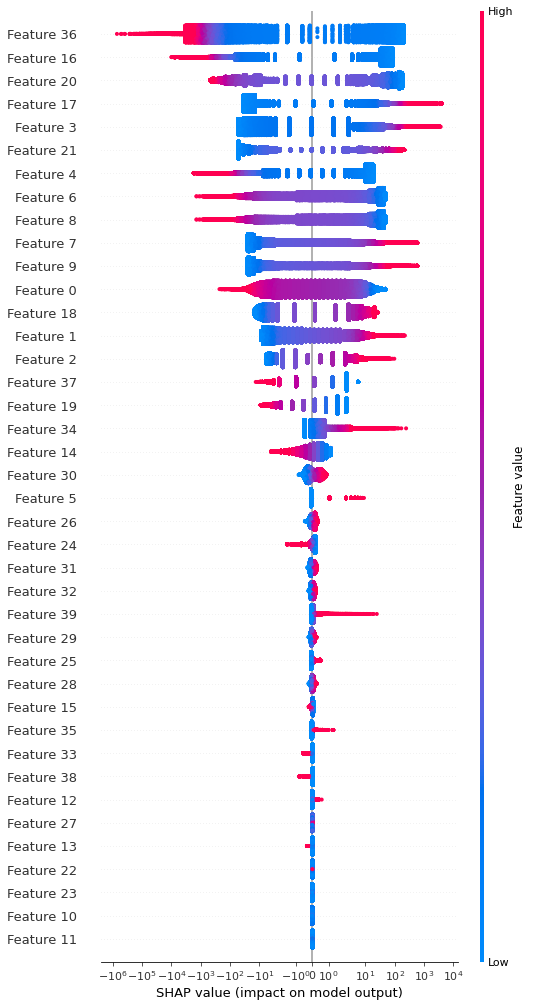

In [108]:
shap.summary_plot(shap_values, X_train, use_log_scale=True, max_display=X_train.shape[1])


In [109]:
mask = [11, 10, 23, 22]
X_train, X_val = np.delete(X_train, mask, axis=1), np.delete(X_val, mask, axis=1)
y_pred, model = train(X_train, X_val, y_train, y_val, normalize = True, model = LogisticRegression(max_iter = 1000))

Validation loss = 0.0989


### Optimize

In [ ]:
def objective(search_space):
    model = RandomForestClassifier(**search_space, n_jobs=6, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)
    y_pred = y_pred[:,1]
    return {'loss': log_loss(y_val, y_pred), 'status': STATUS_OK}
# new search space
search_space={'n_estimators':hp.randint('n_estimators',200,1000),
              
              'max_depth': hp.randint('max_depth',10,200),           
            
            'min_samples_split':hp.uniform('min_samples_split',0,1),   
             'min_samples_leaf':hp.randint('min_samples_leaf',1,10),
              
               'criterion':hp.choice('criterion',['gini','entropy']),
                
           'max_features':hp.choice('max_features',['sqrt', 'log2'])
             }

X_train, X_val, y_train, y_val = load_matrix(validation = True)

# implement Hyperopt
algorithm=tpe.suggest

best_params = fmin(
  fn=objective,
  space=search_space,
  algo=algorithm,
  max_evals=100)

print(best_params)

In [ ]:
def objective(search_space):
    model = LogisticRegression(**search_space, max_iter=1000)
    # X_train, X_val, y_train, y_val = load_matrix(validation = True)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)
    y_pred = y_pred[:,1]
    return {'loss': log_loss(y_val, y_pred), 'status': STATUS_OK}
  
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.fit_transform(X_val)
  
search_space={'solver': hp.choice('solver', ['lbfgs']),
              'penalty': hp.choice('penalty', ['l2', 'none']),
              'C':hp.choice('C', [100, 10, 1.0, 0.1, 0.01])}

algorithm=tpe.suggest

best_params = fmin(
  fn=objective,
  space=search_space,
  algo=algorithm,
  max_evals=10)

# Test matrix

In [74]:
G_train = nx.read_edgelist('data/edgelist_test.txt', delimiter=',', create_using=nx.Graph(), nodetype=int)
G_test = nx.read_edgelist('data/edgelist.txt', delimiter=',', create_using=nx.Graph(), nodetype=int)


In [ ]:
G_authors_train = nx.read_weighted_edgelist('data/citation_graph_test.txt', delimiter=',', create_using=nx.Graph(), nodetype=int)
G_authors_train.remove_edges_from(nx.selfloop_edges(G_authors_train))

G_authors_test = nx.read_weighted_edgelist('data/citation_graph_complete.txt', delimiter=',', create_using=nx.Graph(), nodetype=int)
G_authors_train.remove_edges_from(nx.selfloop_edges(G_authors_train))

## Matrix creation/loading and submission

In [89]:
create_default_matrix(G_train, G_test, validation = False)

Loading unique authors preprocessed
Loading abstract preprocessed


436781it [01:16, 5709.62it/s] 
106692it [00:22, 4726.16it/s]


In [40]:
create_param_matrix(G_train, G_test, validation = False)

436781it [00:10, 39714.21it/s]
106692it [00:01, 82004.27it/s]


In [ ]:
create_param_matrix(G_authors_train, G_authors_test, authors = True, validation = False)

In [28]:
distance = spatial.distance.cosine #spatial.distance.cosine #euclidean_distance #
create_embeddings_matrix(distance = distance, validation = False)

n_features = 6


436781it [01:44, 4188.06it/s]
106692it [00:25, 4254.30it/s]


In [15]:
create_edge_embeddings_matrix(validation = False)

n_features = 1280


436781it [00:06, 64955.40it/s]
106692it [00:01, 70277.18it/s]


In [ ]:
measures = [salton_index, adamic_adar_index, jaccard_coefficient, pref_attachment, shortest_path_length, hub_depressed_index, resource_allocation_index]
create_new_feature_matrix(G_train, G_test, measures = measures, validation = False)

In [ ]:
create_new_feature_matrix(G_authors_train, G_authors_test, autors = True, measures = measures, validation = False)

In [111]:
X_train, X_test, y_train = concatenate_matrix(default = True, param = True, authors_param = True, embeddings = True, 
                                                    edge_embeddings = False, new_feature = True, authors_new_feature = False,
                                              validation = False)

In [112]:
y_pred, model = train(X_train, X_test, y_train, y_test = None, model = LogisticRegression(max_iter = 1500))

Creating submission
Submision created


In [113]:
df_train = pd.DataFrame(data = X_train)
df_train.head(-40)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,168.0,34.0,4.0,31.0,1.0,0.0,496.683333,48.816667,496.683333,48.816667,...,0.480954,0.728612,0.745894,0.129099,0.418577,0.068966,240.0,2.0,0.125000,0.029259
1,245.0,43.0,14.0,138.0,94.0,0.0,211.132445,62.322100,211.132445,62.322100,...,0.285760,0.598979,0.660542,0.059386,0.745455,0.022222,2552.0,2.0,0.025862,0.069359
2,237.0,25.0,11.0,866.0,820.0,0.0,202.770643,165.316313,202.770643,165.316313,...,0.322742,0.305678,0.128526,0.021545,0.837482,0.003476,19389.0,2.0,0.003559,0.083892
3,108.0,42.0,5.0,18.0,8.0,0.0,33.984615,3.215385,33.984615,3.215385,...,0.102442,0.689577,0.654362,0.000000,0.000000,0.000000,65.0,3.0,0.000000,0.000000
4,174.0,8.0,12.0,20.0,2.0,0.0,40.030303,9.303030,40.030303,9.303030,...,0.433182,0.863966,0.692288,0.000000,0.000000,0.000000,99.0,3.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436736,202.0,12.0,3.0,46.0,20.0,0.0,484.717949,58.051282,484.717949,58.051282,...,0.052791,0.258725,0.102600,0.000000,0.000000,0.000000,429.0,3.0,0.000000,0.000000
436737,360.0,220.0,7.0,56.0,52.0,0.0,25.259259,16.259259,25.259259,16.259259,...,0.190334,0.280383,-0.018292,0.000000,0.000000,0.000000,108.0,6.0,0.000000,0.000000
436738,155.0,55.0,2.0,6.0,2.0,0.0,15.000000,2.000000,15.000000,2.000000,...,0.066005,0.237775,0.051447,0.000000,0.000000,0.000000,8.0,7.0,0.000000,0.000000
436739,122.0,2.0,3.0,16.0,6.0,0.0,347.400000,92.600000,347.400000,92.600000,...,0.124385,0.354304,0.016541,0.000000,0.000000,0.000000,55.0,3.0,0.000000,0.000000


### SHAP

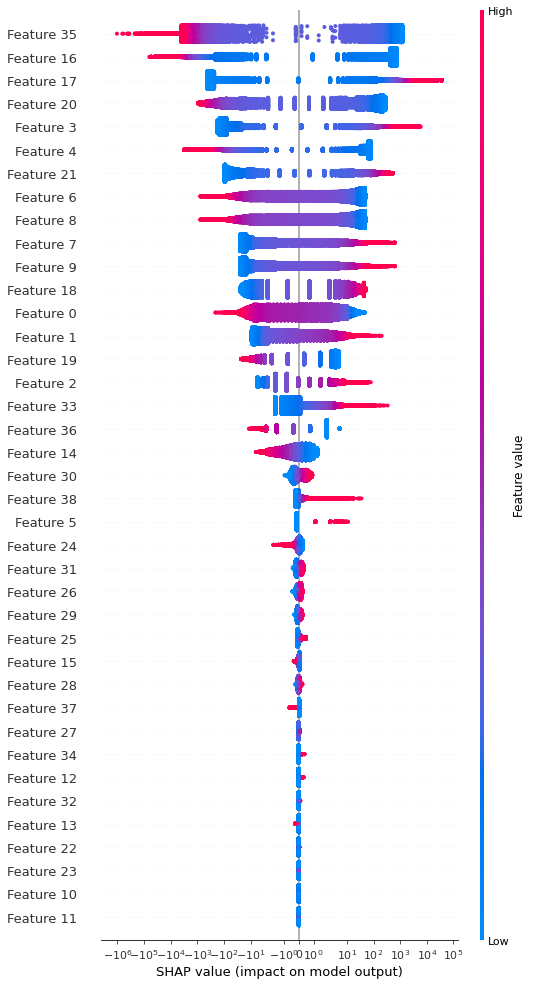

In [114]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, use_log_scale=True, max_display=X_train.shape[1])

In [98]:
mask = [11, 10, 23, 22]
X_train, X_test = np.delete(X_train, mask, axis=1), np.delete(X_test, mask, axis=1)

In [99]:
y_pred, model = train(X_train, X_test, y_train, y_test = None, model = LogisticRegression(max_iter = 1500))

Creating submission
Submision created
